In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from definitions import ROOT_DIR

In [2]:
import pandas as pd
import numpy as np

In [3]:
from src.features.multi_omics import MultiOmicsData

lusc_data = MultiOmicsData(cancer_type="LUSC", 
                           folder_path=ROOT_DIR+"/data/tcga-assembler/LUSC/", 
                           modalities=["GE", "MIR"])

/opt/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


('DRUGS', (357, 4))
('PATIENTS', (504, 5))
('MIR', (380, 1870))
('GE', (552, 20472))


In [4]:
centroids = pd.read_csv(ROOT_DIR+"/data/external/wilkerson.scc/predictor.centroids.csv")
centroids.columns = ["genes", "primitive", "classical", "secretory", "basal"]
centroids = centroids[centroids["genes"].isin(lusc_data.GE.get_genes_list())]
centroid_genes = centroids["genes"]

In [5]:
centroids.index = centroids.genes
centroids.drop(['genes'], axis=1, inplace=True)
centroids = centroids.T
centroids

genes,MYL6B,PODXL2,HSF2,TTLL4,MARCKSL1,MDK,CHKA,TRIM28,STOM,CASP1,...,ALDH1A3,DSE,MMP10,VDR,CAPZB,FNBP1,ENPP4,SH2B3,DOCK10,SDC1
primitive,0.539568,0.852272,0.293831,0.679557,1.015985,1.001421,0.513166,0.569403,-0.737997,-0.775559,...,-0.231312,-0.521502,-0.862938,-0.421701,-0.015213,-0.016889,0.232617,-0.178687,-0.121821,-0.764157
classical,-0.139755,-0.019997,0.060404,-0.089302,-0.306555,-0.019797,-0.150269,0.021242,-0.065057,-0.187048,...,-0.485903,-0.462036,-0.649346,-0.259443,-0.216407,-0.103185,-0.276022,-0.169656,-0.137791,0.337130
secretory,-0.084411,-0.104802,-0.131566,-0.044189,0.012595,-0.202898,0.235328,-0.264212,0.297794,0.305713,...,0.325191,0.487990,-0.974158,0.384095,0.180478,0.421356,0.482619,0.533466,0.569353,-0.998660
basal,-0.033551,-0.053003,-0.079130,-0.084657,0.097278,-0.222180,-0.136313,0.011287,0.043434,0.063549,...,0.905489,0.509466,2.926716,0.309637,0.216626,-0.185309,-0.147701,-0.030816,-0.093761,0.419894


# Subsetting the GE data to only genes

In [6]:
lusc_ge = lusc_data.GE.data[centroid_genes]


# Subset the LUSC samples to only tumor samples
lusc_ge = lusc_ge[lusc_ge.index.str.contains("-01A")]

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-np.max(np.abs(centroids.values)), np.max(np.abs(centroids.values))))
# scaler = MinMaxScaler()
# scaler.fit(centroids)

# Classify LUSC patients based on cluster centroids obtained from Wilkenson, et. al

TODO Read paper "The molecular portraits of breast tumors are conserved across microarray platforms" on how to do subtype prediction

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)

In [9]:
kmeans.cluster_centers_ = centroids.values

In [10]:
lusc_subtypes_map = {0: 'Primitive', 1: 'Classical', 2: 'Secretory', 3: 'Basal'}

lusc_subtypes_pred = pd.DataFrame(kmeans.predict(scaler.fit_transform(lusc_ge)), index=lusc_ge.index)
lusc_subtypes_pred.columns = ["subtype"]
lusc_subtypes_pred.replace({"subtype": lusc_subtypes_map}, inplace=True)
lusc_subtypes_pred["subtype"].value_counts(sort=False, normalize=False)

Secretory     40
Primitive     23
Classical    221
Basal        212
Name: subtype, dtype: int64

# Assign predicted subtypes to LUSC patients samples

In [11]:
lusc_subtypes_pred["patient_barcode"] = lusc_subtypes_pred.index.str[:-4]

lusc_data.add_subtypes_to_patients_clinical(dict(zip(lusc_subtypes_pred["patient_barcode"], lusc_subtypes_pred["subtype"])))

In [15]:
X, y = lusc_data.load_data(multi_omics=["GE"], 
#                            target=["ajcc_pathologic_tumor_stage"], 
                           target=["predicted_subtype"], 
                           predicted_subtypes=["Basal"], 
#                            pathologic_stages=['Stage I', 'Stage II', 'Stage III', 'Stage IV']
                          )
print X["GE"].shape , y.shape

(234, 20472) (234, 1)


# Putative Associations

In [16]:
from src.data.make_dataset import Target_Scan
target_scan = Target_Scan(mirna_list=lusc_data.MIR.get_genes_list(), gene_symbols=lusc_data.GE.get_genes_list())

# Load miRanda putative miRNA-target associations
miRanda_df = pd.read_table(os.path.join(ROOT_DIR, 'data/external/miRanda_hg19_predictions_S_C_aug2010.txt'), delimiter='\t')
miRanda_df = miRanda_df[['mirna_name',  'gene_symbol']]

miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.lower()
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("*", "")
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("-3p.*|-5p.*", "")
print miRanda_df.shape

miRanda_df.columns = ["MiRBase ID", "Gene Symbol"]
miRanda_df = miRanda_df[miRanda_df['MiRBase ID'].isin(lusc_data.MIR.get_genes_list()) & miRanda_df['Gene Symbol'].isin(lusc_data.GE.get_genes_list())].dropna().drop_duplicates()
print miRanda_df.shape

# Union TargetScan and MiRanDa miRNA-target associations
targetScan_df = target_scan.get_miRNA_target_interaction_context()
putative_assocs = pd.concat([targetScan_df, miRanda_df]).dropna().drop_duplicates()
print putative_assocs.shape

(1097064, 2)
(532659, 2)
(603489, 2)


In [52]:
all_mirna_gene_assc = []
for m in lusc_data.MIR.get_genes_list():
    for t in lusc_data.GE.get_genes_list():
        all_mirna_gene_assc.append((m, t))
print len(all_mirna_gene_assc)
all_mirna_gene_assc = pd.DataFrame(all_mirna_gene_assc, columns=["MiRBase ID", "Gene Symbol"])
print all_mirna_gene_assc.shape

38282640
(38282640, 2)


# Run MDSN dysregulation analyses

In [ ]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import warnings
warnings.filterwarnings('ignore')

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Secretory"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Classical"])
network_subtype_sc = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_sc.fit(tag="Secretory-Classical", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Classical"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Basal"])
network_subtype_cb = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_cb.fit(tag="Classical-Basal", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Secretory"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Basal"])
network_subtype_sb = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_sb.fit(tag="Secretory-Basal", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Secretory"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Primitive"])
network_subtype_sp = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_sp.fit(tag="Secretory-Primitive", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Classical"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Primitive"])
network_subtype_cp = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_cp.fit(tag="Classical-Primitive", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Basal"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], predicted_subtypes=["Primitive"])
network_subtype_bp = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
print network_subtype_bp.fit(tag="Basal-Primitive", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

network_norm_tumor = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
A, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], pathologic_stages=["Normal"])
B, _ = lusc_data.load_data(multi_omics=["MIR", "GE"], pathologic_stages=["Stage I"],
                          )
print network_norm_tumor.fit(tag="Normal-tumor", p_threshold=0.01, n_jobs=8,
            miRNA_A=A["MIR"],
            gene_A=A["GE"],
            miRNA_B=B["MIR"],
            gene_B=B["GE"],
            putative_assocs=all_mirna_gene_assc)

n_A 28
n_B 154


In [19]:
# Write graph to file
import networkx as nx

nx.write_gml(network_subtype_sc.B, path="./LUSC/network_subtype_sc_-2_t.gml")
nx.write_gml(network_subtype_cb.B, path="./LUSC/network_subtype_cb_-2_t.gml")
nx.write_gml(network_subtype_sb.B, path="./LUSC/network_subtype_sb_-2_t.gml")
nx.write_gml(network_subtype_sp.B, path="./LUSC/network_subtype_sp_-2_t.gml")
nx.write_gml(network_subtype_cp.B, path="./LUSC/network_subtype_cp_-2_t.gml")
nx.write_gml(network_subtype_bp.B, path="./LUSC/network_subtype_bp_-2_t.gml")

# Combine subtypes dysregulation networks into one

In [ ]:
import networkx as nx

def relabel_mapping(node):
    # HACK: This function is used to relabel target nodes in the miRNA-target bipartite graph such that target nodes
    # in each distinct bipartite graphs have different names
    if "hsa-" in node:
        return node
    else:
        return node+"_"+str(np.random.randint(1000)) # a random number, so each run gives a "probably" different relabeling
    
nx.relabel_nodes(network_subtype_sc.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_cb.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_sb.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_sp.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_cp.B, relabel_mapping, copy=False)
nx.relabel_nodes(network_subtype_bp.B, relabel_mapping, copy=False)

In [21]:
network_subtypes = nx.compose_all([network_subtype_sc.B, network_subtype_cb.B, network_subtype_sb.B,
                                  network_subtype_sp.B, network_subtype_cp.B, network_subtype_bp.B])

network_subtypes_combined = miRNATargetNet(miRNAs=lusc_data.MIR.get_genes_list(), targets=lusc_data.GE.get_genes_list())
network_subtypes_combined.B = network_subtypes

# sorted(network_subtypes.nodes())

In [22]:
print len(network_subtype_sc.B.edges())
print len(network_subtype_cb.B.edges())
print len(network_subtype_sb.B.edges())
print len(network_subtype_sp.B.edges())
print len(network_subtype_cp.B.edges())
print len(network_subtype_bp.B.edges())
print len(network_norm_tumor.B.edges())
print len(network_subtypes_combined.B.edges())

21307
14154
17712
13976
21301
19074
28892
107494


# Bipartite Graph Analysis

In [23]:
import networkx as nx
from networkx.algorithms import bipartite
import copy

# g = network_subtypes.to_undirected()
g = copy.deepcopy(network_subtypes_combined.B.to_undirected())
g.remove_nodes_from(list(nx.isolates(g)))


miRNAs_nodes = set(n for n, d in g.nodes(data=True) if d['bipartite'] == 0)
targets_nodes = set(g) - miRNAs_nodes
print 'mirnas', len(miRNAs_nodes)
print 'targets', len(targets_nodes)
print 'edges',len(g.edges())

mirnas 256
targets 46906
edges 107494


In [24]:
import scipy
import scipy.sparse as sparse

adj = bipartite.biadjacency_matrix(g, row_order=miRNAs_nodes, column_order=targets_nodes)
print adj.shape
cosine_adj = 1-scipy.spatial.distance.pdist(adj.toarray(), "cosine")

(256, 46906)


## Testing approximate scale-free topology criterion by plotting log10(P(k)) v.s. log10(k). A straight line indicates scale-free topology

In [25]:
import matplotlib.pyplot as plt
k_power=1
# cosine_adj_hist_dist = scipy.stats.gaussian_kde(np.power(cosine_adj, k_power))
cosine_adj_hist = np.histogram(np.power(cosine_adj, k_power), bins=500)
cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)

plt.scatter(x=np.log10(np.power(cosine_adj, k_power)),
            y=np.log10(cosine_adj_hist_dist.pdf(np.power(cosine_adj, k_power))), 
            marker='.')
plt.xlabel("np.log10(k)")
plt.ylabel("np.log10(P(k))")
plt.show()

<Figure size 640x480 with 1 Axes>

In [26]:
k_power = 1
c = np.log10(np.power(cosine_adj, k_power))
d = np.log10(cosine_adj_hist_dist.pdf(np.power(cosine_adj, k_power)))

d_ = d[np.where(c != -np.inf)]
d_ = d_[np.where(d_ != -np.inf)]
c_ = c[np.where(d != -np.inf)]
c_ = c_[np.where(c_ != -np.inf)]

print np.count_nonzero(~np.isnan(d_))
print np.max(c_), np.min(c_), len(c_)
print np.max(d_), np.min(d_), len(d_)
print np.power(scipy.stats.pearsonr(c_, d_)[0], 2)

18807
-0.14763337435233226 -2.9496579513534624 18807
2.3439658897143474 -1.8125529750326799 18807
0.8696461575288602


## Graph Distribution of the Cosine Similarity Connections

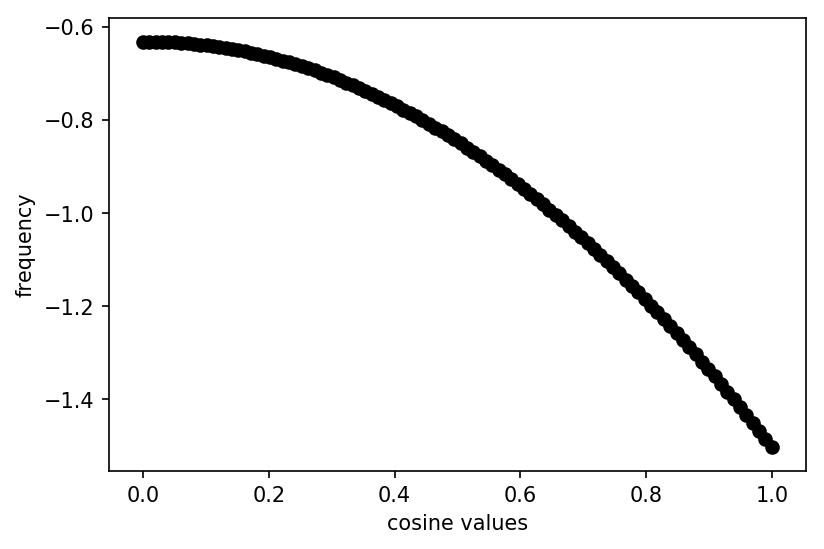

In [27]:
from sklearn.neighbors.kde import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(np.array(cosine_adj)[:,np.newaxis])
x_data = np.linspace(0., 1., 100)[:, np.newaxis]
kde_samples = kde.score_samples(x_data)

plt.figure(dpi=150)
plt.scatter(x=x_data, y=kde_samples, c="black")
# plt.ylim(0, 200)
# plt.xlim(0, 0.2)
plt.ylabel("frequency")
plt.xlabel("cosine values")
plt.show()

## Hard-thresholding

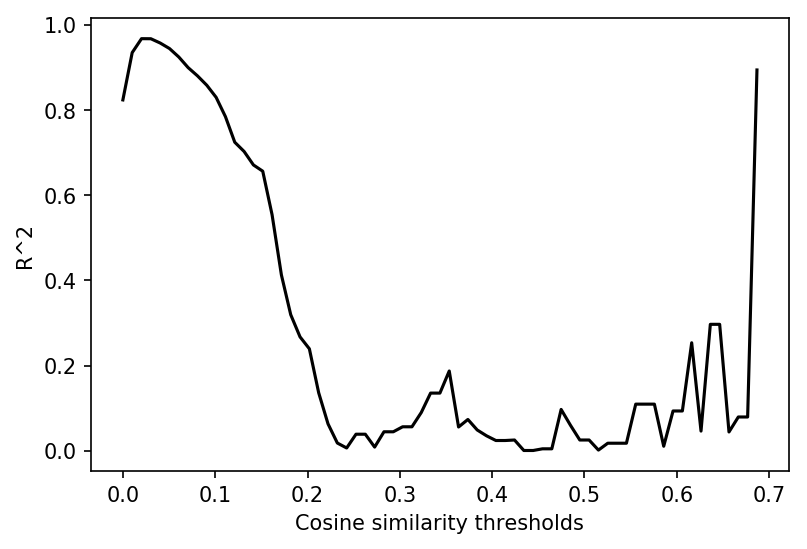

In [28]:
R_thresholds = np.linspace(0,1,100)
r_sqrs = []
k_power = 1
    
for threshold in R_thresholds:
    samples = np.power(cosine_adj, k_power)
    samples[(samples < threshold)] = 0
#     samples = samples[(samples > threshold)]

    cosine_adj_hist = np.histogram(samples, bins=100)
    cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)
    c = np.log10(samples)
    d = np.log10(cosine_adj_hist_dist.pdf(samples))
    
    d_ = d[np.where(c != -np.inf)]
    d_ = d_[np.where(d_ != -np.inf)]
    c_ = c[np.where(d != -np.inf)]
    c_ = c_[np.where(c_ != -np.inf)]
    
    r_sqr = scipy.stats.pearsonr(c_, d_)
    r_sqr = r_sqr[0]*r_sqr[0]
    r_sqrs.append(r_sqr)

# print B[np.argmax(r_sqrs)]
plt.figure(dpi=150)
# plt.scatter(x=R_thresholds, y=r_sqrs, marker='.', c="black")
plt.plot(R_thresholds, r_sqrs, c="black")
plt.ylabel("R^2")
plt.xlabel("Cosine similarity thresholds")
plt.show()

## Soft-thresholding

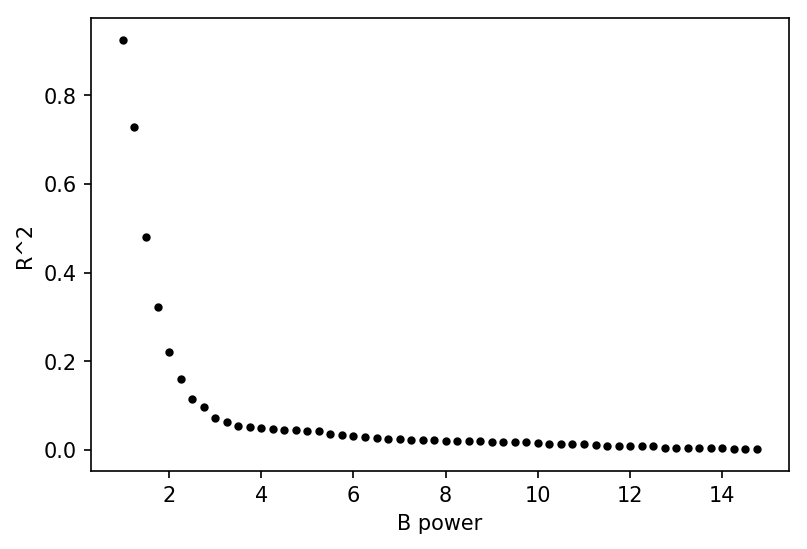

In [29]:
B = np.arange(1,15,0.25)
r_sqrs = []

for b in B:
    k_power = b
    samples = np.power(cosine_adj, k_power)
    
    cosine_adj_hist = np.histogram(samples, bins=200)
    cosine_adj_hist_dist = scipy.stats.rv_histogram(cosine_adj_hist)
    c = np.log10(samples)
    d = np.log10(cosine_adj_hist_dist.pdf(samples))

    d_ = d[np.where(c != -np.inf)]
    d_ = d_[np.where(d_ != -np.inf)]
    c_ = c[np.where(d != -np.inf)]
    c_ = c_[np.where(c_ != -np.inf)]
    
    r_sqr = scipy.stats.pearsonr(c_, d_)
    r_sqr = r_sqr[0]*r_sqr[0]
    r_sqrs.append(r_sqr)

# print B[np.argmax(r_sqrs)]
plt.figure(dpi=150)
plt.scatter(x=B, y=r_sqrs, marker='.', c="black")
plt.ylabel("R^2")
plt.xlabel("B power")
plt.show()

In [30]:
# threshold = np.percentile(np.power(cosine_adj,3), 60)
threshold = 0.4
print threshold

0.4


In [31]:
k_power = 1
cosine_adj_sq = scipy.spatial.distance.squareform(np.power(cosine_adj, k_power))
cosine_adj_sq[np.where(cosine_adj_sq < threshold)] = 0
m = nx.from_numpy_matrix(cosine_adj_sq, create_using=nx.Graph())
m = nx.relabel_nodes(m, {index: miRNA for (index, miRNA) in enumerate(miRNAs_nodes)})
print "edges", len(m.edges())

edges 31


In [32]:
print len(set(m))
m.remove_nodes_from(list(nx.isolates(m)))
print "non-isolate nodes", len(set(m))
layout = nx.spring_layout(m, 
                          weight='weight',
                          k=10.1/np.sqrt(g.number_of_nodes()),
                          iterations=50)

256
non-isolate nodes 29


In [33]:
from bokeh.models import ColumnDataSource

nodes, nodes_coordinates = zip(*sorted(layout.items()))
nodes_xs, nodes_ys = list(zip(*nodes_coordinates))
nodes_source = ColumnDataSource(dict(x=nodes_xs, y=nodes_ys,
                                     name=[n[4:] for n in nodes]))

In [34]:
from bokeh.plotting import show, figure
from bokeh.io import output_notebook
from bokeh.layouts import widgetbox
from bokeh.models import HoverTool, LabelSet
from bokeh.models import Toggle, BoxAnnotation, CustomJS

hover = HoverTool(tooltips=[('name', '@name')])
plot = figure(plot_width=875, plot_height=700,
              tools=['tap', hover, 'box_zoom', 'reset', 'pan'])
r_circles = plot.circle('x', 'y', source=nodes_source, size=5,
                        color='blue', level = 'overlay')
hover.renderers.append(r_circles)

plot.xgrid.grid_line_color = None
plot.ygrid.grid_line_color = None

# layout = bl([p], [toggle])
# show(layout)

In [35]:
def get_edges_specs(_network, _layout):
    d = {'xs': [], 'ys': [], 'alphas': [], 'name': []}
    weights = [data['weight'] for u, v, data in _network.edges(data=True)]
    calc_alpha = lambda h: 0.1 + 0.9*h

    for u, v, data in _network.edges(data=True):
        d['xs'].append([_layout[u][0], _layout[v][0]])
        d['ys'].append([_layout[u][1], _layout[v][1]])
        d['alphas'].append(calc_alpha(data['weight']))
        d['name'].append(str(u)+'<=>'+str(v))
    return d

lines_source = ColumnDataSource(get_edges_specs(m, layout))

r_lines = plot.multi_line('xs', 'ys', line_width=1.5,
                          alpha='alphas', color='black',
                          source=lines_source)
r_lines = plot.multi_line('xs', 'ys', line_width=1.5,
                          alpha='alphas', color='black',
                          source=lines_source)
# show(plot)

In [36]:
centrality =\
    nx.algorithms.centrality.betweenness_centrality(m)
# first element are nodes again
_, nodes_centrality = zip(*sorted(centrality.items()))
max_centrality = max(nodes_centrality)
nodes_source.add([7 + 10 * t / max_centrality
                  for t in nodes_centrality],
                 'centrality')

import community # python-louvain
partition = community.best_partition(m, weight="weight")
p_, nodes_community = zip(*sorted(partition.items()))
nodes_source.add(nodes_community, 'community')
community_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628', '#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']
nodes_source.add([community_colors[t % len(community_colors)]
                  for t in nodes_community],
                 'community_color')

print np.bincount(partition.values()), len(np.unique(partition.values()))

[2 4 2 7 2 2 2 2 2 2 2] 11


In [37]:
from bokeh.io import output_notebook, show
output_notebook()

r_circles.glyph.size = 'centrality'
r_circles.glyph.fill_color = 'community_color'

proc_labels = LabelSet(x='x', y='y', text="name", 
                       text_font_size="8pt", text_color="navy",
                       source=nodes_source, text_align='center')

plot.add_layout(proc_labels)

code = '''\
if toggle.active
    labels.visible = true
    console.log 'enabling box'
else
    labels.visible = false
    console.log 'disabling box'
'''
callback = CustomJS.from_coffeescript(code=code, args={})
toggle = Toggle(label="Toggle miRNA label", button_type="success", callback=callback)
callback.args = {'toggle': toggle, 'labels': proc_labels}

show(plot)
show(toggle)

Loading BokehJS ...

## Multi-clusters analysis with rand index

In [38]:
tn_partition = network_norm_tumor.get_miRNA_community_assgn(threshold=0.01, power=1)

sc_partition = network_subtype_sc.get_miRNA_community_assgn(threshold=0.01, power=1)
cb_partition = network_subtype_cb.get_miRNA_community_assgn(threshold=0.01, power=1)
sb_partition = network_subtype_sb.get_miRNA_community_assgn(threshold=0.01, power=1)
sp_partition = network_subtype_sp.get_miRNA_community_assgn(threshold=0.01, power=1)
cp_partition = network_subtype_cp.get_miRNA_community_assgn(threshold=0.01, power=1)
bp_partition = network_subtype_bp.get_miRNA_community_assgn(threshold=0.01, power=1)

com_partition = network_subtypes_combined.get_miRNA_community_assgn(threshold=0.01, power=1)

mirnas 235
targets 9392
edges 28892
edges after threshold: 11325
mirnas 247
targets 8649
edges 21307
edges after threshold: 8612
mirnas 250
targets 7109
edges 14154
edges after threshold: 7336
mirnas 247
targets 7987
edges 17712
edges after threshold: 7091
mirnas 242
targets 6794
edges 13976
edges after threshold: 5819
mirnas 247
targets 8424
edges 21301
edges after threshold: 7381
mirnas 248
targets 7999
edges 19074
edges after threshold: 6846
mirnas 256
targets 46906
edges 107494
edges after threshold: 8350


In [39]:
from sklearn import metrics
from src.models.miRNA_target_network import miRNATargetNetwork

partitions = {"Secretory vs Classical":miRNATargetNetwork.group_assg_list(sc_partition, lusc_data.MIR.get_genes_list()),
             "Classical vs Basal":miRNATargetNetwork.group_assg_list(cb_partition, lusc_data.MIR.get_genes_list()),
             "Secretory vs Basal":miRNATargetNetwork.group_assg_list(sb_partition, lusc_data.MIR.get_genes_list()),
             "Secretory vs Primitive":miRNATargetNetwork.group_assg_list(sp_partition, lusc_data.MIR.get_genes_list()),
             "Classical vs Primitive":miRNATargetNetwork.group_assg_list(cp_partition, lusc_data.MIR.get_genes_list()),
             "Basal vs Primitive":miRNATargetNetwork.group_assg_list(bp_partition, lusc_data.MIR.get_genes_list()),
             "combined":miRNATargetNetwork.group_assg_list(com_partition, lusc_data.MIR.get_genes_list()),
             "tumor vs normal":miRNATargetNetwork.group_assg_list(tn_partition, lusc_data.MIR.get_genes_list()),
             "miRNA family":target_scan.get_miRNA_family_group_assg()}
# keys = partitions.keys()
keys = ['Secretory vs Classical', 'Classical vs Basal', 'Secretory vs Basal', 'Secretory vs Primitive', 'Classical vs Primitive',
        'Basal vs Primitive', "combined", 'tumor vs normal', 'miRNA family']

m = []
for p in keys:
    n = []
    for q in keys:
        n.append(miRNATargetNetwork.cluster_similarity(partitions[p], partitions[q], metric="nmi"))
    m.append(n)
#         if p < q:
#             print p,"vs", q,"\t", miRNATargetNetwork.cluster_similarity(partitions[p], partitions[q], metric="rand")
print m
m = np.asarray(m)

[[1.0, 0.2370252421667425, 0.4422398441186664, 0.2235098041226937, 0.19399505545760928, 0.20013127985549511, 0.287495677907918, 0.19349079225828852, 0.5121716725405835], [0.2370252421667425, 1.0, 0.23651307969927907, 0.24639217306993655, 0.24467728380751322, 0.23875353023894344, 0.290980848561054, 0.24311682293743458, 0.504719425613527], [0.4422398441186664, 0.23651307969927907, 1.0, 0.26610326717931326, 0.1955916067014776, 0.18735657787566923, 0.313037309794171, 0.1705491472608447, 0.528427751869081], [0.2235098041226937, 0.24639217306993655, 0.26610326717931326, 1.0, 0.3483149798647212, 0.36684415832480816, 0.4371790673807312, 0.1988240032829028, 0.5131102750616091], [0.19399505545760926, 0.24467728380751322, 0.1955916067014776, 0.3483149798647212, 1.0, 0.5564558345937165, 0.482274801792817, 0.1785260419748345, 0.4853669519022005], [0.20013127985549514, 0.23875353023894338, 0.18735657787566923, 0.36684415832480816, 0.5564558345937165, 1.0, 0.4388270509565779, 0.1563314804589875, 0.48

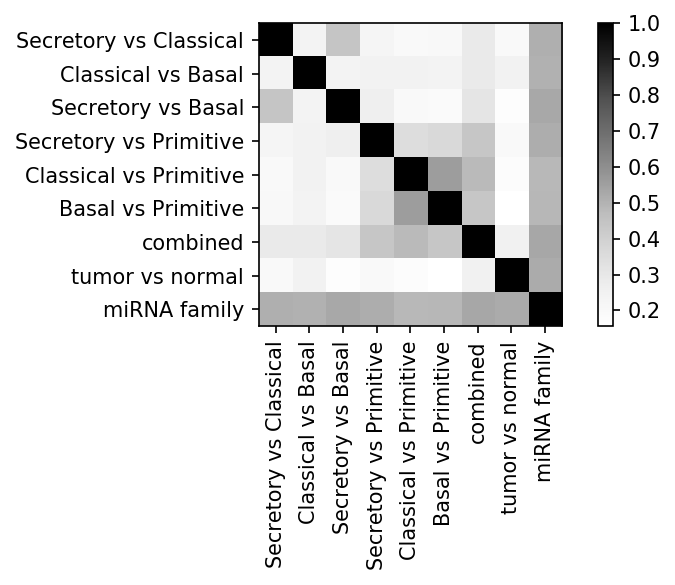

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='miRNA clusters similarity between different subtype dysregulation analyses',
                          cmap=plt.cm.Greys):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

plt.figure(dpi=150)
plot_confusion_matrix(m, keys)
plt.show()

# 
# 
# 
# Prepare samples for Classification task

In [43]:
from sklearn.model_selection import train_test_split


# X_normal, _ = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"], 
#                                   pathologic_stages=["Normal"])
X, y = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"])
#                            samples_barcode=X_normal["MIR"].index)
X = X["MIR"]
stage_label_mapping = {'Normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1}
y["ajcc_pathologic_tumor_stage"] = y["ajcc_pathologic_tumor_stage"].replace(stage_label_mapping)


X_multi, y_multi = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"])
X_multi = X_multi["MIR"]
stage_label_mapping = {'Normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4}
y_multi["ajcc_pathologic_tumor_stage"] = y_multi["ajcc_pathologic_tumor_stage"].replace(stage_label_mapping)


X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)

print "X", X.shape
print "y", y.shape
print "X_multi", X_multi.shape
print "y_multi", y_multi.shape
print y["ajcc_pathologic_tumor_stage"].value_counts()
print y_multi["ajcc_pathologic_tumor_stage"].value_counts()

X (377, 1870)
y (377, 1)
X_multi (377, 1870)
y_multi (377, 1)
 1    333
-1     44
Name: ajcc_pathologic_tumor_stage, dtype: int64
1    155
2    125
3     50
0     44
4      3
Name: ajcc_pathologic_tumor_stage, dtype: int64


In [ ]:
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Group Lasso L2
# group_l2_param = param.copy()
# group_l2_param['loss'] = 'weighted-logistic'
# group_l2_param['regul'] = 'group-lasso-l2'
# group_l2 = SPAMSClassifier()
# group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# Sparse Group Lasso
sparse_group_l2_param = param.copy()
sparse_group_l2_param['loss'] = 'logistic'
sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2_param['lambda1'] = 0.2
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=partitions["combined"], params=sparse_group_l2_param)

# Multi Logistic
multi_task_l1l2_param = param.copy()
multi_task_l1l2_param['loss'] = 'multi-logistic'
multi_task_l1l2_param['regul'] = 'l1l2'
multi_task_l1l2_param['max_it'] = 200
multi_task_l1l2_param['lambda1'] = 0.5
multi_task_l1l2 = SPAMSClassifier()
multi_task_l1l2.fit(X_multi_train, Y_multi_train, groups=None, params=multi_task_l1l2_param)

## PARSIMONY Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [45]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors
from src.models.miRNA_target_network import miRNATargetNetwork

# X, y = luad_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"])
# X = X["MIR"]

# print X.shape, y.shape
# X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
#                               pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
#                               stage_label_mapping={'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

groups_for_sgl = miRNATargetNetwork.list_of_groups(
    network_subtypes_combined.get_miRNA_community_assgn(), lusc_data.MIR.get_genes_list())

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   groups_for_sgl)

beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=4.5, l2=0.0, gl=5.5, A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)
## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer
print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

mirnas 256
targets 46906
edges 107494
edges after threshold: 1988


/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Class "ZerosStartVector" is deprecated (use "ZerosWeights" instead).
/opt/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: Function or method "get_vector" is deprecated (use "get_weights" instead).


Non-zero: 634


## OneVsRestClassifier

In [49]:
from sklearn.multiclass import OneVsRestClassifier
from src.models.group_lasso_spams import LRSGLWrapper

# lrsgl_one_vs_rest = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=5, A=A, max_iter=500))
# lrsgl_one_vs_rest.fit(X=X_multi_train, y=Y_multi_train)

lr_one_vs_rest = OneVsRestClassifier(LRSGLWrapper(l1=2.5, l2=0.0, gl=0, max_iter=1000))
lr_one_vs_rest.fit(X=X_multi_train, y=Y_multi_train)

/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Class "ZerosStartVector" is deprecated (use "ZerosWeights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Function or method "get_vector" is deprecated (use "get_weights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Class "ZerosStartVector" is deprecated (use "ZerosWeights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Function or method "get_vector" is deprecated (use "get_weights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmPro

OneVsRestClassifier(estimator=LRSGLWrapper(A=None, gl=0, l1=2.5, l2=0.0, max_iter=1000),
          n_jobs=1)

(301, 1870) (301, 5)
(76, 1870) (76, 5)


/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Class "ZerosStartVector" is deprecated (use "ZerosWeights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Function or method "get_vector" is deprecated (use "get_weights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Class "ZerosStartVector" is deprecated (use "ZerosWeights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmProjects/assn-miRNA-LUAD/src/models/group_lasso_spams.py:32: DeprecationWarning: Function or method "get_vector" is deprecated (use "get_weights" instead).
  beta = start_vectors.ZerosStartVector().get_vector(X.shape[1])
/home/jonny_admin/PycharmPro

ROC micro 0.815746191135734
ROC macro 0.7038167596266269


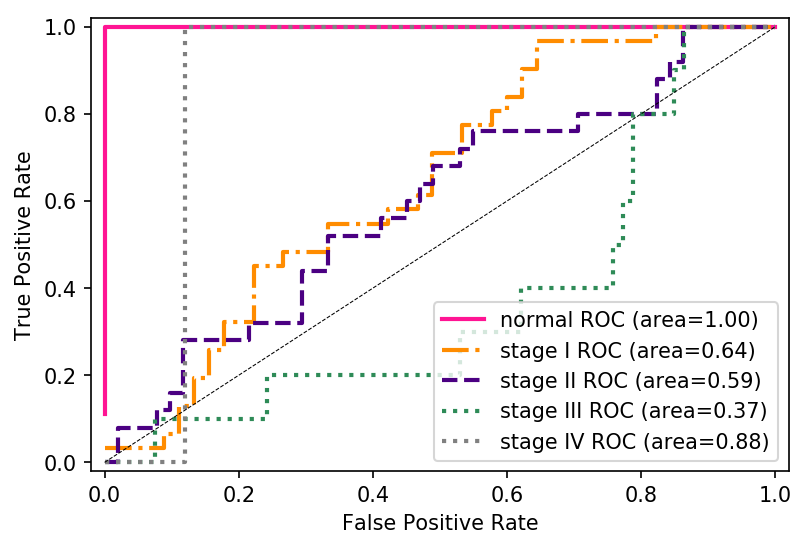

In [50]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

# X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
#                               pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
#                               stage_label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4})

X, y = lusc_data.load_data(multi_omics=["MIR"], target=["ajcc_pathologic_tumor_stage"])
X = X["MIR"]
stage_label_mapping = {'Normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 3, 'Stage IV': 4}
y["ajcc_pathologic_tumor_stage"] = y["ajcc_pathologic_tumor_stage"].replace(stage_label_mapping)

y = label_binarize(y, classes=[0, 1, 2, 3, 4])
n_classes = 5
n_samples, n_features = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=0)
print X_train.shape, y_train.shape
print X_test.shape, y_test.shape

def roc_auc_w_group():
    colors = cycle(['darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
    linestyles = cycle(['solid', 'dashed', 'dashdot', 'dotted'])
    lw = 2

    lr_ovr_with_sgl = OneVsRestClassifier(copy.deepcopy(LRSGLWrapper(l1=1.5, l2=0.0, gl=3.5, 
                                                       A=gl.linear_operator_from_groups(X_train.shape[1],
                                                           groups_for_sgl), 
                                                       max_iter=1000)))
    lr_ovr_with_sgl.fit(X_train, y_train)

#     metrics.classification_report(y_test, lr_ovr_with_sgl.predict(X_test))

    y_score = lr_ovr_with_sgl.predict_proba(X_test)

    j = 0

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(dpi=150)
    print 'ROC micro', roc_auc["micro"]
    print 'ROC macro', roc_auc["macro"]

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = cycle(['deeppink', 'darkorange', 'indigo', 'seagreen', 'gray', 'red', 'cyan'])
    linestyles = cycle(['solid', 'dashdot', '--', 'dotted', ':'])
    for i, color, linestyle in zip(range(n_classes), colors, linestyles):
        if i == 0:
            label = 'normal'
        elif i==1:
            label = 'stage I'
        elif i==2:
            label = 'stage II'
        elif i==3:
            label = 'stage III'
        elif i==4:
            label = 'stage IV'

        plt.plot(fpr[i], tpr[i], color=color, lw=lw, linestyle=linestyle,
                 label='{0} ROC (area={1:0.2f})'
                 ''.format(label, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=0.5)
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
roc_auc_w_group()